# Exploring `build_cutouts` outputs

This jupyter notebook analyse the `build_cutout.py` **outputs**. Cutouts are returning wind, solar and run-off river relevant timeseries that are created with the Atlite tool (wind speeds, solar iradiation, etc.). We recommend going through [Atlite's notebooks](https://github.com/PyPSA/atlite/tree/master/examples) to learn more about it's fantastic capabilities.

The `pypsa-earth/Snakefile` explicitly list in the **rule** what goes into the function `build_cutouts.py` and what goes out (`networks/{cutout}.nc`). So to create the i.e. wind speed timeseries, we only need to provide shapes of the area of interest as input and automatically can create outputs.

```
if config['enable'].get('build_cutout', False):
    rule build_cutout:
        input:
            regions_onshore="resources/regions_onshore.geojson",
            regions_offshore="resources/regions_offshore.geojson"
        output: "cutouts/{cutout}.nc"
        log: "logs/build_cutout/{cutout}.log"
        benchmark: "benchmarks/build_cutout_{cutout}"
        threads: ATLITE_NPROCESSES
        resources: mem=ATLITE_NPROCESSES * 1000
        script: "scripts/build_cutout.py"
```

Before analysing the outputs of add_electricity.py check that:
- `pypsa-earth` environment (/kernel) in jupyter notebook  is active and updated
- root folder where pypsa-earth is installed is named "pypsa-earth"
- or rename the below `sets_path_to_root("<folder_name>")` accordingly

In [1]:
# change current directory
import os
import sys

module_path = os.path.abspath(os.path.join('../../')) # To import helpers
if module_path not in sys.path:
    sys.path.append(module_path+"/pypsa-earth/scripts")
    
from _helpers import sets_path_to_root

sets_path_to_root("pypsa-earth-project")

ModuleNotFoundError: No module named '_helpers'

A jupyter notebook requires the user to import all they need. So we need to import all the required dependencies from the `pypsa-earth` environment:

In [2]:
import atlite
import cartopy.crs as ccrs
import xarray as xr
import geopandas as gpd
import geoviews as gv
import holoviews as hv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer

plt.rcParams["figure.figsize"] = [7, 7]
%matplotlib inline

## Create a cutout (takes quite a while)
If you don't have already an cutout for instance `pypsa-earth/cutouts/africa-2013-era5.nc` in your folder you need to create one (or download one through our google cloud). Note: That we only provide the cutout for whole Africa at the moment. If another regions is of interest you need to do the following:

- Go through the Atlite example: https://github.com/PyPSA/atlite/blob/master/examples/create_cutout.ipynb (as described there, we need to setup some stuff to download cutouts)
- Copy and rename the `config_default.yaml` to `config.yaml`
- Change the `config.yaml` if needed:

```
atlite:
  nprocesses: 4
  cutouts:
    africa-2013-era5:         # This can be renamed for instance mena-2013-era5
      module: era5            # dataset
      dx: 0.3                 # raster/ cutout resolution 
      dy: 0.3                 # raster/ cutout resolution
      time: ["2013", "2013"]  # weather year of interest. 2013 is default. 
```
- provide the input shapes of the **Snakefile rule** for the region of interest. Make sure that for instance `regions_onshore.geojson` contains the data of Middle-East if you want to create a cutout of this area **and** this file need to be located in `pypsa-earth/resources` according to the Snakefile rule:
```    
    input:
            regions_onshore="resources/regions_onshore.geojson",
            regions_offshore="resources/regions_offshore.geojson"
```
- execute the following command when located at `~/pypsa-earth`:
```
    snakemake -j 1 cutouts/africa-2013-era5.nc
    or
    snakemake -j 1 cutouts/mena-2013-era5.nc
```
, depending on which name you defined in the `config.yaml` **and** in the `Snakefile`

## Let's open the cutouts = weather/environment cells
Cutouts in Atlite are rasterized weather and environment cells. They are produced in the `build_cutouts.py` and lead to the output `africa-2013-era5.nc` which is stored in the `pypsa-earth/cutouts` folder. We read first the path and open then the .nc file with xarray. As you can see from the ploted content below there is quite a lot data available. All data variabes are grided (x,y) and most of them even over time. Let's have a look.

In [4]:
weather_cell_path = "C:/Users/xenia/Desktop/Thesis_Code/Code/pypsa-earth_working/pypsa-earth/cutouts/southamerica-2013-era5.nc"
weather_cell = xr.load_dataset(weather_cell_path)

## Using Atlite we can use some plotting examples

Applied from https://atlite.readthedocs.io/en/latest/examples/plotting_with_atlite.html

In [5]:
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

import logging
import warnings

warnings.simplefilter("ignore")
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

### Create shapes for Bolivia

In [7]:
shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_0_countries"
)
reader = shpreader.Reader(shpfilename)
NG = gpd.GeoSeries(
    {r.attributes["NAME_EN"]: r.geometry for r in reader.records()},
    crs={"init": "epsg:4326"},
).reindex(["Bolivia"])

### Load cutout
- Will appear in the `pypsa-earth/cutouts/` after one run the pypsa-earth workflow

In [8]:
cutout_path = os.path.join(
    'C:/Users/xenia/Desktop/Thesis_Code/Code/pypsa-earth_working/pypsa-earth/cutouts/southamerica-2013-era5.nc'
)
cutout = atlite.Cutout(path=cutout_path)
cutout.data

<xarray.Dataset>
Dimensions:           (x: 45, y: 48, time: 8760)
Coordinates:
  * x                 (x) float64 -70.2 -69.9 -69.6 -69.3 ... -57.6 -57.3 -57.0
  * y                 (y) float64 -23.4 -23.1 -22.8 -22.5 ... -9.9 -9.6 -9.3
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
    lon               (x) float64 dask.array<chunksize=(45,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(48,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(48, 45), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 48, 45), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 48, 45), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 48, 45), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 48, 45), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 48, 45), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 48, 45), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 48, 45), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 48, 45), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 48, 45), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 48, 45), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 48, 45), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['height', 'runoff', 'influx', 'wind', 'temperature']
    chunksize_time:     100
    dx:                 0.3
    dy:                 0.3
    Conventions:        CF-1.6
    history:            2023-05-19 18:41:27 GMT by grib_to_netcdf-2.25.1: /op...

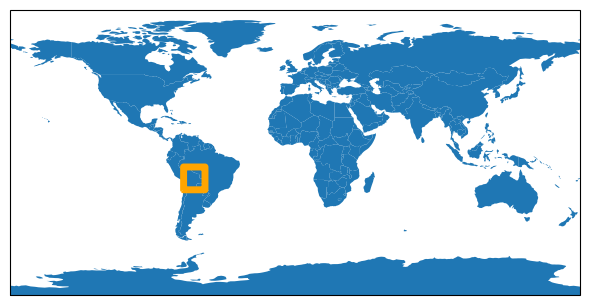

In [9]:
%matplotlib inline
cells = cutout.grid.buffer(0.001)
df = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
country_bound = gpd.GeoSeries(cells.unary_union)

projection = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(6, 6))
df.plot(ax=ax, transform=plate())
country_bound.plot(
    ax=ax, edgecolor="orange", linewidth=5, facecolor="None", transform=plate()
)
fig.tight_layout()

# plt.savefig("cutout-earthplot-nigeria.pdf", bbox_inches='tight')

<GeoAxesSubplot:>

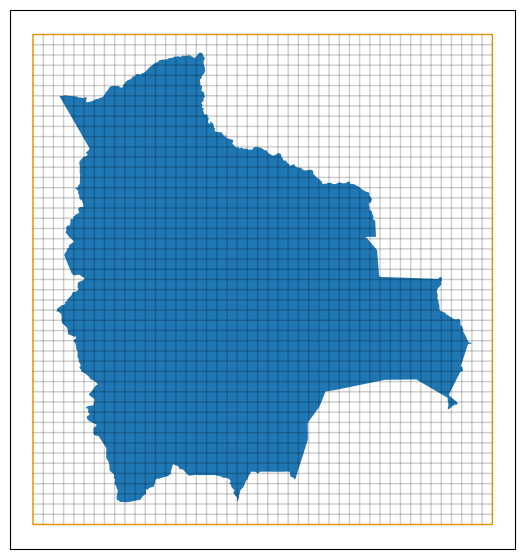

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(2, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
plot_grid_dict = dict(
    alpha=0.1,
    edgecolor="k",
    zorder=4,
    aspect="equal",
    facecolor="None",
    transform=plate(),
)
NG.plot(ax=ax, zorder=1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
country_bound.plot(ax=ax, edgecolor="orange", facecolor="None", transform=plate())
#ax.outline_patch.set_edgecolor("white")

# ax1 = fig.add_subplot(gs[0, 2])
# cutout.data.wnd100m.mean(["x", "y"]).plot(ax=ax1)
# ax1.set_frame_on(False)
# ax1.set_ylabel("Mean 100m wind speed")
# ax1.xaxis.set_visible(False)

# ax2 = fig.add_subplot(gs[1, 2], sharex=ax1)
# cutout.data.influx_direct.mean(["x", "y"]).plot(ax=ax2)
# ax2.set_frame_on(False)
# ax2.set_xlabel(None)
# ax2.set_ylabel("Mean direct influx")
# fig.tight_layout()

# # plt.savefig("onshore-capacity-factor.pdf", bbox_inches='tight')

In [12]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
green1 = '#294839'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#927F48'
beige2 = '#A89677'
beige3 = '#D2CDAD'

plt.rcParams['font.size'] = 18
save_path = "C:/Users/xenia/OneDrive/Desktop/Uni/NTNU/Thesis/Figures/"
val_path = "C:/Users/xenia/OneDrive/Desktop/Uni/NTNU/Thesis/Figures/Validation/"

INFO:atlite.convert:Convert and aggregate 'wind'.


<xarray.DataArray 'Capacity Factor' ()>
array(0.06499378, dtype=float32)


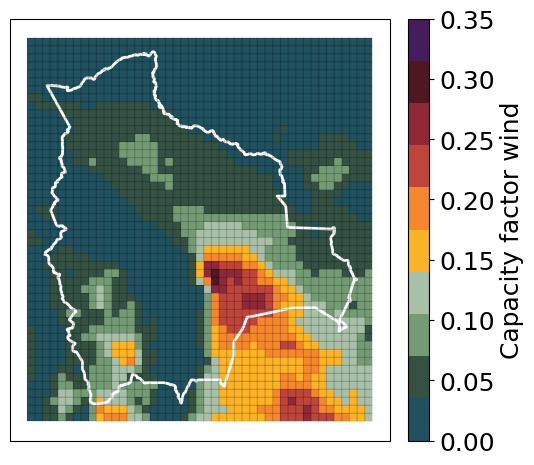

INFO:atlite.convert:Convert and aggregate 'pv'.


[########################################] | 100% Completed | 2.67 s


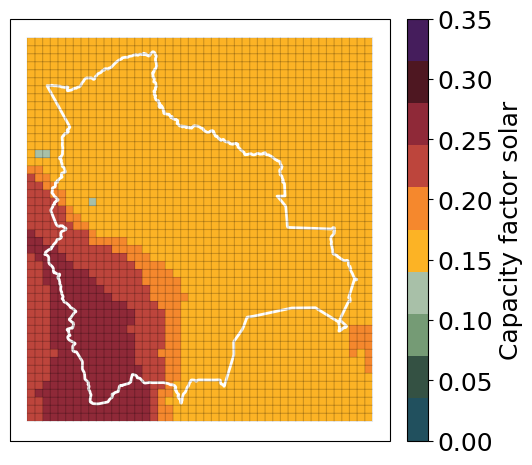

In [16]:
from matplotlib.colors import LinearSegmentedColormap, Normalize

cmap = 'turbo'
# vmin = 0
# vmax = 0.3

from matplotlib.colors import ListedColormap

# Define your custom colormap
colors = [teal2,green1,green2,green3, yellow, orange,red2,red1,brown,purple1]
cmap = ListedColormap(colors)

%matplotlib inline
cap_factors = cutout.wind(turbine="Vestas_V112_3MW", capacity_factor=True)

vmin = 0
vmax = 0.35

#norm = Normalize(vmin=vmin, vmax=vmax)
#norm_cap_factors = norm(cap_factors)

fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(7, 5))
cap_factors.name = "Capacity Factor"
im = cap_factors.plot(ax=ax, transform=plate(), alpha=0.95,cmap = cmap, vmin = vmin, vmax=vmax)
cells.plot(ax=ax, **plot_grid_dict, linewidth=0.8)
NG.plot(ax=ax, zorder=1, facecolor='none', edgecolor='white',linewidth = 2,  transform=plate())
fig.tight_layout();
print(cap_factors.mean())
ax = plt.gca()

# Remove the colorbar
cbar = ax.collections[0].colorbar
cbar.remove()
fig.colorbar(im, ax=ax, fraction=0.049, pad=0.03, label = 'Capacity factor wind')
plt.savefig(val_path + "capacity_factors_wind.pdf", dpi=300,bbox_inches='tight')
plt.show()

%matplotlib inline
cap_factors = cutout.pv(panel = 'CSi', orientation='latitude_optimal', capacity_factor=True)

fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(7, 5))
#cap_factors.name = "Capacity Factor"
im = cap_factors.plot(ax=ax, transform=plate(), alpha=0.95,cmap = cmap, vmin=vmin, vmax =vmax)
cells.plot(ax=ax, **plot_grid_dict, linewidth=0.8)
NG.plot(ax=ax, zorder=1, facecolor='none', edgecolor='white', linewidth = 2, transform=plate())
# Get the current axes
ax = plt.gca()

# Remove the colorbar
cbar = ax.collections[0].colorbar
cbar.remove()
fig.colorbar(im, ax=ax, fraction=0.049, pad=0.03, label = 'Capacity factor solar')
fig.tight_layout();

plt.savefig(val_path + "capacity_factors_solar.pdf", dpi=300,bbox_inches='tight')

INFO:atlite.convert:Convert and aggregate 'wind'.


TypeError: unhashable type: 'numpy.ndarray'

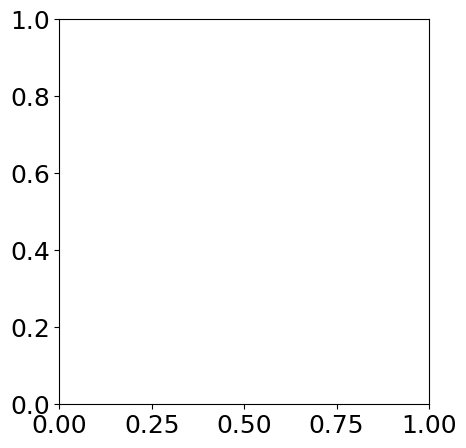

In [40]:
import geopandas as gpd
import xarray as xr
import rasterio as rio
from shapely.geometry import box
import matplotlib.pyplot as plt

home = 'C:/Users/xenia/Desktop/Thesis_Code/Code/pypsa-earth_working/pypsa-earth/'

# Read the shapefile as a GeoDataFrame
r = gpd.read_file(home + "resources/bus_regions/regions_onshore_elec_s_4.geojson").set_index("name")

# Extract the boundary as a GeoDataFrame
zones = gpd.GeoDataFrame(geometry=r.boundary)


# Assuming you have a GeoDataFrame 'zones' containing the shape of Bolivia zones
cap_factors = cutout.wind(turbine="Vestas_V112_3MW", capacity_factor=True)

# Get the spatial bounds of the capacity factors data
cap_factors_bounds = cap_factors.rio.bounds()

# Convert the capacity factors bounds to a shapely box
cap_factors_box = box(*cap_factors_bounds)

# Perform zonal statistics to calculate the average capacity factor for each zone
zone_avg_cf = []
for zone in zones.geometry:
    mask = zone.intersects(cap_factors_box)
    mask_array = xr.DataArray(mask, dims=cap_factors.dims, coords=cap_factors.coords)
    zone_cf = cap_factors.where(mask_array, drop=True)
    avg_cf = zone_cf.mean().values
    zone_avg_cf.append(avg_cf)

# Add the average capacity factor to the GeoDataFrame
zones['average_capacity_factor'] = zone_avg_cf

# Plot the average capacity factor for each zone
fig, ax = plt.subplots(figsize=(7, 5))
zones.plot(ax=ax, column='average_capacity_factor', cmap='viridis', edgecolor='white', linewidth=0.8)

# Set plot labels and title
plt.xlabel('Zone')
plt.ylabel('Average Capacity Factor')
plt.title('Average Capacity Factor by Zone')

# Save or display the plot




INFO:atlite.convert:Convert and aggregate 'wind'.


TypeError: unhashable type: 'numpy.ndarray'

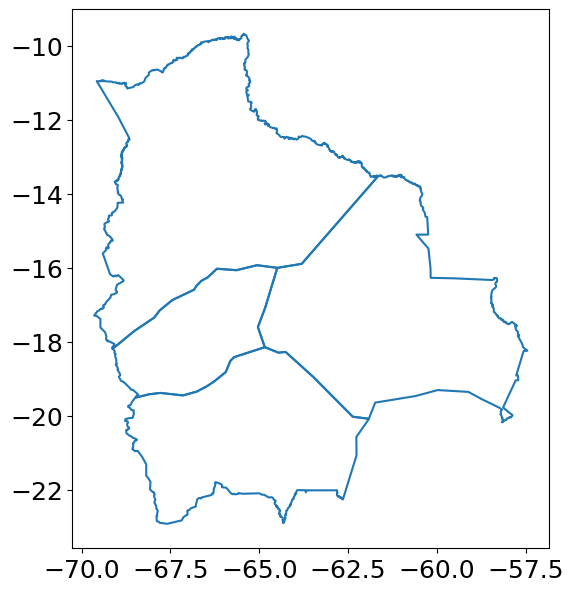

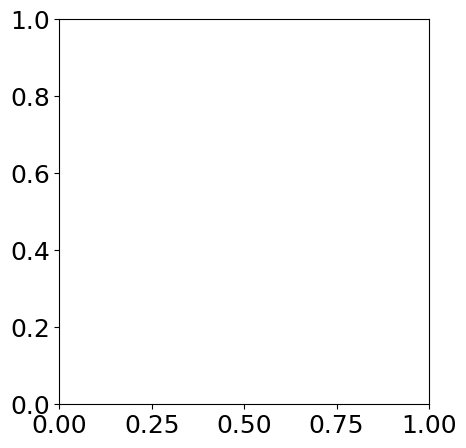

In [42]:
import geopandas as gpd
import xarray as xr
import rasterio as rio
from shapely.geometry import box
import matplotlib.pyplot as plt

home = 'C:/Users/xenia/Desktop/Thesis_Code/Code/pypsa-earth_working/pypsa-earth/'

# Read the shapefile as a GeoDataFrame
r = gpd.read_file(home + "resources/bus_regions/regions_onshore_elec_s_4.geojson")

# Extract the boundary as a GeoDataFrame
zones = gpd.GeoDataFrame(geometry=r.boundary)

# Plot the boundary of the zones
zones.plot()

# Assuming you have a GeoDataFrame 'zones' containing the shape of Bolivia zones
cap_factors = cutout.wind(turbine="Vestas_V112_3MW", capacity_factor=True)

# Get the spatial bounds of the capacity factors data
cap_factors_bounds = cap_factors.rio.bounds()

# Convert the capacity factors bounds to a shapely box
cap_factors_box = box(*cap_factors_bounds)

# Perform zonal statistics to calculate the average capacity factor for each zone
zone_avg_cf = []
for zone in zones.geometry:
    mask = zone.intersects(cap_factors_box)
    mask_array = xr.DataArray(mask, dims=cap_factors.dims, coords=cap_factors.coords)
    zone_cf = cap_factors.where(mask_array, drop=True)
    avg_cf = zone_cf.mean().values
    zone_avg_cf.append(avg_cf)

# Add the average capacity factor to the GeoDataFrame
zones['average_capacity_factor'] = zone_avg_cf

# Plot the average capacity factor for each zone
fig, ax = plt.subplots(figsize=(7, 5))
zones.plot(column='average_capacity_factor', cmap='viridis', edgecolor='white', linewidth=0.8, ax=ax)

# Set plot labels and title
plt.xlabel('Zone')
plt.ylabel('Average Capacity Factor')
plt.title('Average Capacity Factor by Zone')

# Save or display the plot
# val_path = "path/to/save/plot/"
# plt.savefig(val_path + "average_capacity_factor_zones
